# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_m\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_n\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta u = \frac{2 d^{\frac{1}{p}}}{n^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Lap}(\frac{2S}{\epsilon})$, where $\epsilon$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.


_____

# 0. Helper Functions

In [1]:
%matplotlib inline

import sys
print(sys.version)
import argparse
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import pdb
import sys
import time
import tensorflow as tf
print(tf.__version__)
from scipy.stats import ks_2samp, truncnorm
from scipy.spatial.distance import pdist, squareform

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
1.13.1


In [2]:
def get_support_points(x, num_support, max_iter=1000, lr=1e-2, is_tf=False):
    # Initialize generated particles for both sets (y and y_).
    d = x.shape[1]
    offset = 0.1

    if Y_INIT_OPTION == 'grid':
        grid_size = int(np.sqrt(num_support))
        assert grid_size == np.sqrt(num_support), 'num_support must square for grid'
        _grid = np.linspace(offset, 1 - offset, grid_size)
        y = np.array(np.meshgrid(_grid, _grid)).T.reshape(-1, d)
        # Perturb grid in order to give more diverse gradients.
        y += np.random.normal(0, 0.005, size=y.shape)

    elif Y_INIT_OPTION == 'random':
        y = np.random.uniform(offset, 1 - offset, size=(num_support, d))
        
    elif Y_INIT_OPTION == 'radial':
        positions = np.linspace(0, (2 * np.pi) * num_support / (num_support + 1), num_support)
        y = [[0.5 + 0.25 * np.cos(rad), 0.5 + 0.25 * np.sin(rad)] for rad in positions]
        y = np.array(y)
    
    # Optimize particles for each dataset (x0 and x1).
    y_opt, e_opt = optimize_support_points(x, y, max_iter=max_iter, learning_rate=lr,
                                           is_tf=is_tf)
    
    # Get last updated set as support points.
    sp = y_opt[-1]
    
    return sp, e_opt

In [3]:
def optimize_support_points(data, gen, max_iter=500, learning_rate=1e-2, is_tf=False):
    """Runs TensorFlow optimization, n times through proposal points.
    Args:
      data: ND numpy array of any length, e.g. (100, dim).
      gen: ND numpy array of any length, e.g. (10, dim).
      max_iter: Scalar, number of times to loop through updates for all vars.
      learning_rate: Scalar, amount to move point with each gradient update.
      is_tf: Boolean. Chooses TensorFlow optimization.
      
    Returns:
      y_opt: (max_iter,N,D)-array. Trace of generated proposal points.
      e_opt: Float, energy between data and last iteration of y_out.
    """
    
    if is_tf:
        print('\n  [*] Using TensorFlow optimization.')
        y_out = np.zeros((max_iter, gen.shape[0], gen.shape[1]))

        # Build TensorFlow graph.
        tf.reset_default_graph()
        tf_input_data = tf.placeholder(tf.float32, [None, data.shape[1]], name='input_data')
        tf_candidate_sp = tf.Variable(gen, name='sp', dtype=tf.float32)
        
        tf_e_out, _ = energy(tf_input_data, tf_candidate_sp, power=ENERGY_POWER, is_tf=True)

        #tf_optim = tf.train.AdamOptimizer(learning_rate).minimize(tf_e_out)
        opt = tf.train.AdamOptimizer(learning_rate)
        #opt = tf.train.RMSPropOptimizer(learning_rate)
        #opt = tf.train.GradientDescentOptimizer(learning_rate)
        tf_grads, tf_variables = zip(*opt.compute_gradients(tf_e_out))
        tf_optim = opt.apply_gradients(zip(tf_grads, tf_variables))
        

        # Initialize graph.
        tf_init_op = tf.global_variables_initializer()
        tf_gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
        tf_sess_config = tf.ConfigProto(allow_soft_placement=True, gpu_options=tf_gpu_options)

        # Run training.
        with tf.Session(config=tf_sess_config) as sess:
            sess.run(tf_init_op)

            start_time = time.time()
            
            for it in range(max_iter):
                batch_size = max(100, gen.shape[0] * 10)
                batch_data = data[np.random.choice(len(data), batch_size)]
                
                if it in SAVE_ITER:
                    # Do update over entire data set. [TAKES LONGER]
                    data_, sp_, e_, e_grads_, e_vars_ = sess.run(
                        [tf_input_data, tf_candidate_sp, tf_e_out, tf_grads, tf_variables],
                        {tf_input_data: data})
                    sess.run([tf_optim], {tf_input_data: data})
                else:
                    data_, sp_, e_, e_grads_, e_vars_ = sess.run(
                        [tf_input_data, tf_candidate_sp, tf_e_out, tf_grads, tf_variables],
                        {tf_input_data: batch_data})
                    sess.run([tf_optim], {tf_input_data: batch_data})

                
                # ------------------------------------------------------------------
                # TODO: Decide whether to clip support points to domain bounds.
                sp_ = np.clip(sp_, 0, 1)
                # ------------------------------------------------------------------

                
                # Store result in container.
                y_out[it, :] = sp_

                # Plot occasionally.
                if data.shape[1] == 2 and it in SAVE_ITER and it > 0:
                    if it > 0:
                        print('  [*] Overall it/s: {:.4f}'.format((time.time() - start_time) / it))
                        
                    plt.scatter(data[:,0], data[:,1], c='black', s=64, alpha=0.3, label='data')
                    plt.scatter(sp_[:,0], sp_[:,1], s=32, c='limegreen', label='sp')
                    
                    # Plot arrows of gradients at each point.
                    for i, sp in enumerate(sp_):
                        plt.arrow(sp[0], sp[1], *(-1. * e_grads_[0][i]),
                                  color='white', edgecolor='white',
                                  head_width=0.02, head_length=0.02,
                                  length_includes_head=False)
                    
                    plt.title('it: {}, e_out: {:.8f}'.format(it, e_))
                    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    plt.axis('equal')
                    plt.show()
    
    elif not is_tf:
        print('\n  [*] Using analytical gradient optimization.')
        y_out = np.zeros((max_iter, gen.shape[0], gen.shape[1]))
    
        # Run optimization steps.
        for it in range(max_iter):
            e_, e_grads = energy(data, gen, power=ENERGY_POWER)
            gen -= learning_rate * e_grads

            
            # ------------------------------------------------------------------
            # TODO: Decide whether to clip support points to domain bounds.
            gen = np.clip(gen, 0, 1)
            # ------------------------------------------------------------------
            
            y_out[it, :] = gen

            
            # Plot occasionally.
            if data.shape[1] == 2 and it in SAVE_ITER and it > 0:
                plt.scatter(data[:,0], data[:,1], c='black', s=64, alpha=0.3, label='data')
                plt.scatter(gen[:,0], gen[:,1], s=32, c='limegreen', label='sp')
                
                # Plot arrows of gradients at each point.
                for i, sp in enumerate(gen):
                    plt.arrow(sp[0], sp[1], *(-1. * e_grads[i]),
                              color='white', edgecolor='white',
                              head_width=0.02, head_length=0.02,
                              length_includes_head=False)
                
                plt.title('it: {}, e_out: {:.8f}'.format(it, e_))
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                plt.axis('equal')
                plt.show()
    
    return y_out, e_

In [4]:
def energy(data, gen, power=1., is_tf=False):
    """Computes abbreviated energy statistic between two point sets.

    The smaller the value, the closer the sets.
    Args:
      data: ND numpy array of any length, e.g. (1000, 2).
      gen: ND numpy array of any length, e.g. (10, 2).
      power: Exponent in distance metric. Must be >= 1.
      is_tf: Boolean. Selects for TensorFlow functions.
    Returns:
      e: Scalar, the energy between the sets.
      gradients_e: Numpy array of energy gradients for each proposal point.
    """
    assert power >= 1, 'Power must be >= 1.'


    # ------------- NumPy VERSION -------------

    if not is_tf:
        x = data
        y = gen
        dim = x.shape[1]
        data_num = len(x)
        gen_num = len(y)

        # Compute energy.
        v = np.concatenate((x, y), 0)
        v_tiled_across = np.tile(v[:, np.newaxis, :], (1, v.shape[0], 1))
        v_tiled_down = np.tile(v[np.newaxis, :, :], (v.shape[0], 1, 1))
        pairwise_difs = v_tiled_across - v_tiled_down
        K = np.linalg.norm(pairwise_difs, axis=2, ord=power)

        K_xx = K[:data_num, :data_num]
        K_yy = K[data_num:, data_num:]
        K_xy = K[:data_num, data_num:]
        
        num_combos_x = data_num * (data_num - 1) / 2
        num_combos_y = gen_num * (gen_num - 1) / 2
        num_combos_xy = data_num * gen_num

        e = (2. / gen_num / data_num * np.sum(K_xy) -
             1. / data_num / data_num * np.sum(K_xx) -
             1. / gen_num / gen_num * np.sum(K_yy))
    
        # Compute energy gradients.    
        # Note: Term2 assumes y in first position. For y in second position,
        #       need to multiply grad_matrix by -1.
        if power == 1:
            term1 = np.sign(np.sum(pairwise_difs, axis=2))
            term2 = np.sign(pairwise_difs)
        else:
            c1 = 1. / power
            
            # Define term containing Infs on diag, then replace Infs w/ zero.
            term1 = c1 * np.sum(pairwise_difs ** power, axis=2) ** (c1 - 1)
            #np.fill_diagonal(term1, 0)
            term1[np.where(term1 == np.inf)] = 0

            term2 = power * (pairwise_difs ** (power - 1))
            
            
        assert len(term1[:,:,np.newaxis].shape) == len(term2.shape)
        grad_matrix = term1[:, :, np.newaxis] * term2
        grad_matrix_yx = grad_matrix[data_num:, :data_num]
        grad_matrix_yy = grad_matrix[data_num:, data_num:]

        gradients_e = np.zeros((gen_num, dim))
        for i in range(gen_num):
            grad_yi = (2. / data_num / gen_num * np.sum(grad_matrix_yx[i], axis=0) -
                       2. / gen_num / gen_num * np.sum(grad_matrix_yy[i], axis=0))
            gradients_e[i] = grad_yi
        
    
    # ------------- TensorFlow VERSION -------------
    
    elif is_tf:
        x = data
        y = gen
        dim = tf.shape(x)[1]
        data_num = tf.shape(x)[0]
        gen_num = tf.shape(y)[0]

        # Compute energy.
        v = tf.concat([x, y], 0)
        v_tiled_across = tf.tile(tf.expand_dims(v, 1), [1, tf.shape(v)[0], 1])
        v_tiled_down = tf.tile(tf.expand_dims(v, 0), [tf.shape(v)[0], 1, 1])
        pairwise_difs = v_tiled_across - v_tiled_down
        
        # Replace diagonals (which are zeros) with small value.
        # TODO: WHY IS THIS NEEDED TO AVOID NANs?
        # COMPUTE K WITH FILLER ON DIAG, THEN ZERO OUT DIAG.
        diag_filler = 1e-10 * tf.eye(tf.shape(pairwise_difs)[0])
        diag_filler = tf.tile(
            tf.expand_dims(diag_filler, 2),
            [1, 1, tf.shape(pairwise_difs)[2]])
        pairwise_difs = pairwise_difs + diag_filler
        
        # Define energy over pairwise difs.
        K = tf.norm(pairwise_difs, axis=2, ord=power)
        K = tf.matrix_set_diag(K, tf.zeros(tf.shape(v)[0]))
        
        K_xx = K[:data_num, :data_num]
        K_yy = K[data_num:, data_num:]
        K_xy = K[:data_num, data_num:]
        
        m = tf.cast(data_num, tf.float32)
        n = tf.cast(gen_num, tf.float32)
        
        e = (2. / n / m * tf.reduce_sum(K_xy) -
             1. / m / m * tf.reduce_sum(K_xx) -
             1. / n / n * tf.reduce_sum(K_yy))
        
        gradients_e = None

    return e, gradients_e

____

# 1. Global Config

In [5]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
ENERGY_POWER = 2                 # [2., 1.]
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
DATA_SOURCE = 'balog'            # ['balog', 'gaussian', 'gamma', 'beta']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
SAVE_ITER = [100, 200, 300]  # How often to plot results during training. [100]
LR = 0.01                        # Energy optimization learning rate. [1e-2]
DIFFUSION_SIZE = 1e-2            # Scale of noise diffusion in ExpMech step.
ALPHA = 1                        # Differential privacy level.
M = 200                        # Number of data points.
N = 20                           # Number of support points.
DIM = 2                          # Dimension of data.

___

# 2. Load and Plot Data

In [6]:
if DATA_SOURCE == 'balog':
    os.system('python data.py {} {}'.format(M, DIM))
    
    # Note that Balog's N is our M.
    DATA_PATH = '../data/mixture_of_Gaussians_N{}_D{}.npz'. format(M, DIM)

Loaded M=200 data points with dimension DIM=2


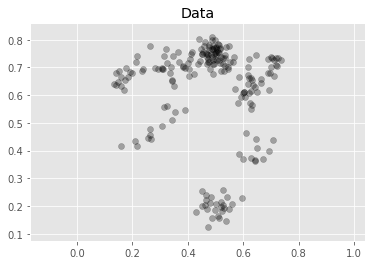

In [7]:
# Load data.
if DATA_SOURCE == 'balog':
    data = np.load(DATA_PATH)
    x = data['X_private']
    assert (M, DIM) == np.shape(x), 'Balog data dims do not match global params.'
    print('Loaded M={} data points with dimension DIM={}'.format(M, DIM))
    plt.scatter(x[:,0], x[:,1], c="black", alpha=0.3);
    plt.title('Data');
    plt.axis('equal')
    plt.show()
    
elif DATA_SOURCE == 'gaussian':
    a, b = -3, 3
    x = truncnorm.rvs(a, b, size=M)
    x = np.sort(x)
    diam_x = b - a

elif DATA_SOURCE == 'beta':
    a, b = 2, 2
    x = np.random.beta(a, b, size=M)
    x = np.sort(x)
    diam_x = 1.

else:
    print('Set up fn for unknown data_source')
    sys.exit()

___

# 3. Run Support Point Optimization


  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0049


/home/maurice/virtualenvironment/py3.5/lib/python3.5/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


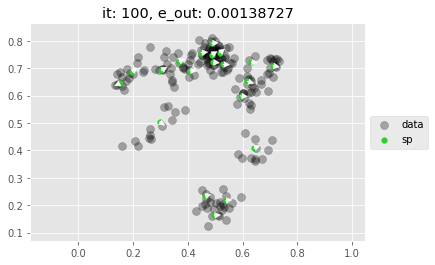

  [*] Overall it/s: 0.0053


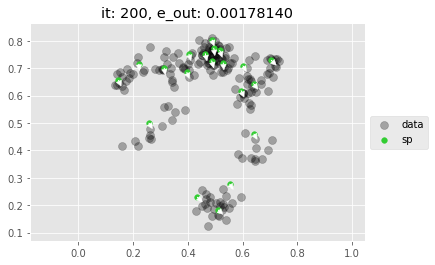

  [*] Overall it/s: 0.0055


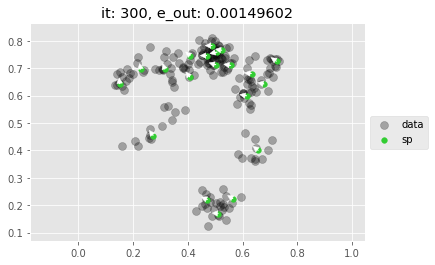

In [8]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

___

# 4. Sample Using Exponential Mechanism

In [9]:
def sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt, method,
                       step_size, num_y_tildes, alpha=1.):
    """Samples in space of support points.
    
    Args:
      e_opt: Energy distance between optimal support points and data.
      energy_sensitivity: Sensitivity, based on user-selected privacy budget.
      x: NumPy array, data.
      y_opt: NumPy array, optimal support points.
      method: String, indicates which sampling method to use.
      step_size: Float, amount to step in diffusion or MH.
      num_y_tildes: Samples of support points to draw.
      alpha: Float, privacy budget.
    
    Returns:
      y_tildes: NumPy array, sampled support point sets.
      energies: NumPy array, energies associated with sampled sets.
    """
    
    # Sample energy distance.
    # TODO: Must be {larger than optimal energy distance, positive}.
    e_tilde = np.abs(np.random.laplace(scale=2. * energy_sensitivity / alpha))
    

    # Sample support points.
    if method == 'diffusion':
        
        # ---------- ALGORITHM 1: DIFFUSE FROM OPTIMAL ----------
        # Start with copy of optimal support points, then diffuse until 
        # energy(true, copy) is at least e_tilde.
            
        y_tildes = np.zeros((num_y_tildes, y_opt.shape[0], y_opt.shape[1]))
        energies = np.zeros(num_y_tildes)
        
        for i in range(num_y_tildes):
            y_tilde = y_opt.copy()
            energy_y_y_tilde = 0.
            count = 0
            max_count = 1e3
            
            while energy_y_y_tilde < e_tilde and count < max_count:
                y_tilde += np.random.normal(0, step_size, size=y_tilde.shape)
                y_tilde = np.clip(y_tilde, 0, 1)

                energy_y_y_tilde, _ = energy(y_opt, y_tilde)

                count += 1

            if count < max_count:
                print(('Diffusion count {:5}, e_opt: {:9.8f}, e~: {:6.3f}, '
                       'energy(y,y~): {:5.3f}, error%: {:.3f}').format(
                    count, e_opt, e_tilde, energy_y_y_tilde,
                    (energy_y_y_tilde - e_tilde) / e_tilde))
            else:
                print('DID NOT REACH E-TILDE LEVEL')
                sys.exit()
                
            
            # Append the accepted energy value to a list for later analysis.
            y_tildes[i] = y_tilde
            energies[i] = energy_y_y_tilde

            
    elif method == 'mh':

        # ----------------- ALGORITHM 2: METROPOLIS HASTINGS -----------------

        # TODO: Let Y* be optimal support points. Initialize Y_t as a sample 
        #   from uniform. Let Y_t' = Y_t + random walk noise. For differential
        #   privacy level a and sensitivity U, define acceptance ratio of Y_t' as
        #     \gamma = exp(a / (2U) * [e(Y_t, Y*) - e(Y_t', Y*)]).
        #   Then accept Y_t' with probability min(1, \gamma).
        
        # Choose setup for Metropolis-Hastings.
        burnin = 10000
        thinning = 100
        chain_length = burnin + thinning * num_y_tildes

        # Initialize the support points Y_t.
        #y_t = np.random.uniform(size=y_opt.shape)
        y_t = y_opt #+ np.random.normal(scale=0.1, size=y_opt.shape)
        energy_init, _ = energy(y_opt, y_t)

        # Create containers for markov chain results.
        y_mh = np.zeros(shape=(chain_length, y_opt.shape[0], y_opt.shape[1]))
        ratios_unthinned = np.zeros(chain_length)
        energies_unthinned = np.zeros(chain_length)
        accepts = []

        for i in range(chain_length):
            # Add random walk noise to current set of support points.
            y_t_candidate = y_t + np.random.normal(scale=step_size, size=y_t.shape)
            y_t_candidate = np.clip(y_t_candidate, 0, 1)
            energy_t, _ = energy(y_opt, y_t)
            energy_t_candidate, _ = energy(y_opt, y_t_candidate)

            # Compute the acceptance ratio.
            ratios_unthinned[i] = np.exp(alpha / (2. * energy_sensitivity) * (energy_t - energy_t_candidate))

            # Accept or reject the candidate.
            if np.random.uniform() < ratios_unthinned[i]:
                accepts.append(i)
                y_t = y_t_candidate
                y_mh[i] = y_t_candidate
                energies_unthinned[i] = energy_t_candidate
            else:
                y_mh[i] = y_t
                energies_unthinned[i] = energy_t

            if i % int(chain_length / 10) == 0:
                # Plot the points.
                plt.scatter(x[:,0], x[:,1], c='black', alpha=0.3, label='data')
                plt.scatter(y_opt[:,0], y_opt[:,1], c='limegreen', label='sp(data)')
                plt.scatter(y_mh[i][:,0], y_mh[i][:,1], c='red', alpha=0.7, label='~sp(data)')
                plt.title('it: {}, e(Yt, Y*)={:.4f}, ratio={:.3f}'.format(
                    i, energies_unthinned[i], ratios_unthinned[i]))
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                plt.axis('equal')
                plt.show()    

        # Thinned results.
        y_tildes = y_mh[burnin::thinning]
        ratios = ratios_unthinned[burnin::thinning]
        energies = energies_unthinned[burnin::thinning]
        dups = [y_tildes[i] == y_tildes[i-1] for i in range(1, len(y_tildes))]

        
        # Plot results of markov chain.
        plt.plot(ratios);
        plt.title('accept_ratios, median={:.5f}'.format(np.median(ratios)));
        plt.show()
        plt.plot(energies);
        plt.title('energies, median={:.5f}'.format(np.median(energies)));
        plt.show()
        print('energy_init={:.5f}'.format(energy_init))

        print('# accepts: {}'.format(len(accepts)))

        # --------------------------------------------------------------
   
    else:
        print('Method not recognized.')

    return y_tildes, energies

Laplace(2 * U / alpha) = Laplace(2 * 0.0071 / 10.00) = Laplace(0.001)
Diffusion count   156, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.007
Diffusion count   268, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.016
Diffusion count   197, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.024
Diffusion count   249, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.004
Diffusion count   184, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.016
Diffusion count   201, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.020
Diffusion count   143, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.010
Diffusion count   144, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.011
Diffusion count   122, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.012
Diffusion count   212, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.001
Diffusion count   162, e_opt: 0.00149602

Diffusion count   180, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.003
Diffusion count   210, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.009
Diffusion count   205, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.015
Diffusion count   236, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.023
Diffusion count   194, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.002
Diffusion count   176, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.003
Diffusion count   212, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.028
Diffusion count   181, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.023
Diffusion count   286, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.002
Diffusion count   334, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.009
Diffusion count   216, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.008
Diffusion count   139

Diffusion count   257, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.020
Diffusion count   212, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.009
Diffusion count   128, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.025
Diffusion count   155, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.034
Diffusion count   237, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.011
Diffusion count    71, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.003
Diffusion count   136, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.016
Diffusion count   185, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.030
Diffusion count   242, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.020
Diffusion count   269, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.002
Diffusion count   172, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.015
Diffusion count   220

Diffusion count   248, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.010
Diffusion count   250, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.023
Diffusion count   290, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.002
Diffusion count   242, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.017
Diffusion count   248, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.006
Diffusion count   156, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.007
Diffusion count   107, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.022
Diffusion count   234, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.007
Diffusion count    81, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.016
Diffusion count   264, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.005
Diffusion count   175, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.021
Diffusion count   152

Diffusion count    95, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.027
Diffusion count   238, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.013
Diffusion count   193, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.017
Diffusion count   223, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.011
Diffusion count   129, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.008
Diffusion count   155, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.003
Diffusion count   139, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.020
Diffusion count   197, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.009
Diffusion count   227, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.012
Diffusion count   201, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.023
Diffusion count   158, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.023
Diffusion count   391

Diffusion count   225, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.010
Diffusion count   138, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.002
Diffusion count   196, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.002
Diffusion count   161, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.015
Diffusion count   154, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.028
Diffusion count   215, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.014
Diffusion count   246, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.019
Diffusion count   184, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.001
Diffusion count   265, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.017
Diffusion count   178, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.020
Diffusion count   210, e_opt: 0.00149602, e~:  0.002, energy(y,y~): 0.002, error%: 0.005
Diffusion count   152

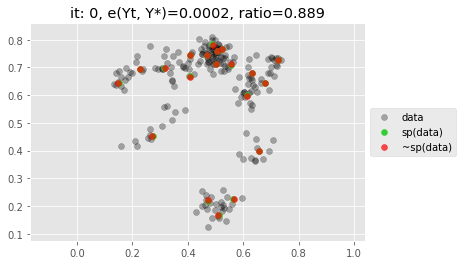

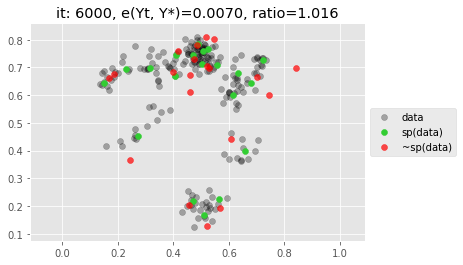

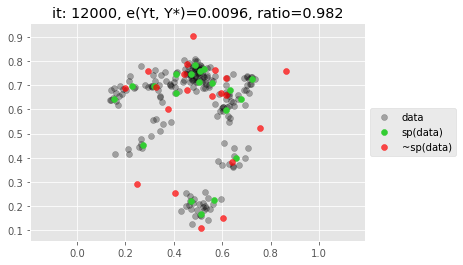

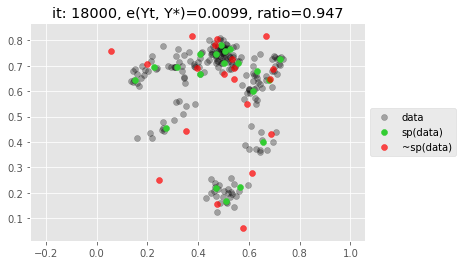

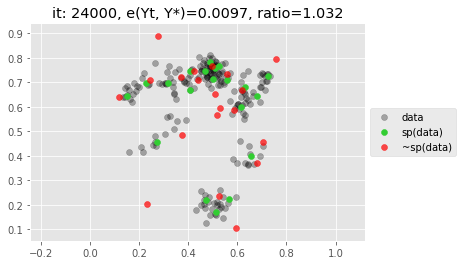

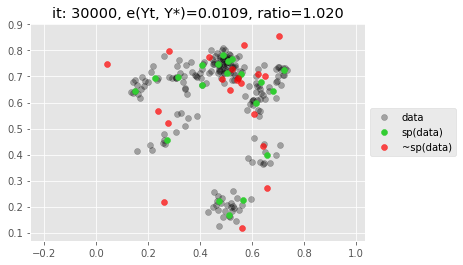

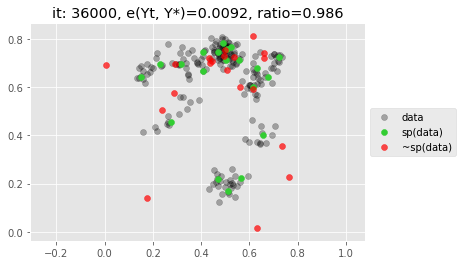

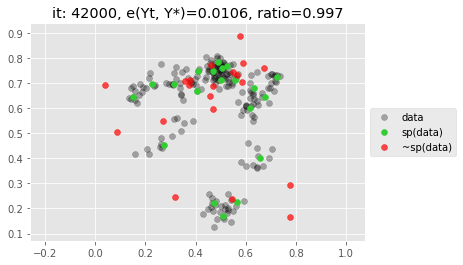

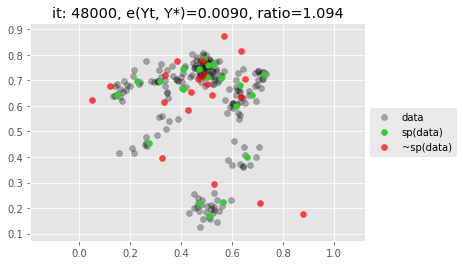

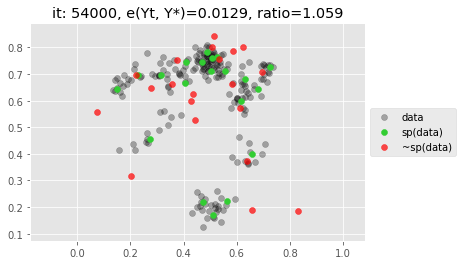

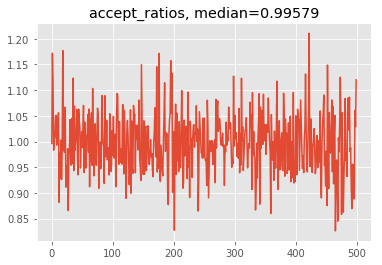

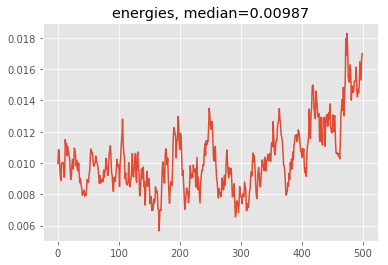

energy_init=0.00000
# accepts: 58723


In [10]:
ALPHA = 10
STEP_SIZE = 1e-3
NUM_Y_TILDES = 500

# Define energy sensitivity for Exponential Mechanism.
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2
print(('Laplace(2 * U / alpha) = Laplace(2 * {:.4f} / {:.2f}) '
       '= Laplace({:.3f})').format(energy_sensitivity, ALPHA, 
                                   2. * energy_sensitivity / ALPHA))

# Sample support points.
METHOD = 'diffusion'
(y_tildes_diffusion,
 energies_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                          METHOD, STEP_SIZE, NUM_Y_TILDES, 
                                          alpha=ALPHA)
METHOD = 'mh'
(y_tildes_mh,
 energies_mh) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                   METHOD, STEP_SIZE, NUM_Y_TILDES, 
                                   alpha=ALPHA)

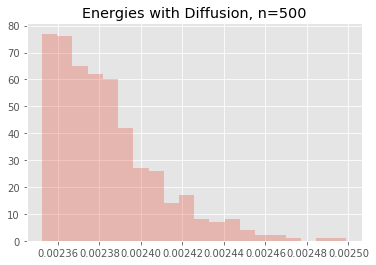

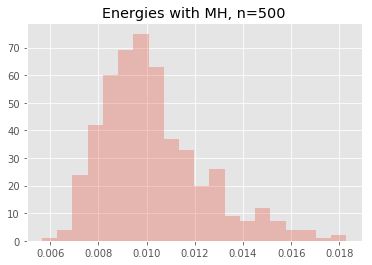

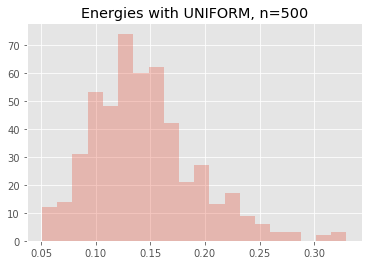

In [11]:
# Compare to energies of e(y_opt, uniform)
baseline_energies = np.zeros(NUM_Y_TILDES)
for i in range(NUM_Y_TILDES):
    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
    baseline_energies[i] = e_

# Plot results.
plt.title('Energies with Diffusion, n={}'.format(len(energies_diffusion)))
plt.hist(energies_diffusion, bins=20, alpha=0.3)
plt.show()

plt.title('Energies with MH, n={}'.format(len(energies_mh)))
plt.hist(energies_mh, bins=20, alpha=0.3)
plt.show()

plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
plt.hist(baseline_energies, bins=20, alpha=0.3)
plt.show()

In [12]:
# Show examples of the sampled support point sets.
if 0:
    random_indices = np.random.choice(range(y_tildes.shape[0]), size=5)

    for i in random_indices:
        # Plot sample results.
        plt.scatter(x[:, 0], x[:, 1], c='black', label='data',
                    alpha=0.3)
        plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', label='sp(data)', s=64)
        plt.scatter(y_tildes[i, :, 0], 
                    y_tildes[i, :, 1],
                    c='red', label='sp(data) + noise', s=16)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(('SP sample {}, ALPHA={}, e_opt={:.6f}, energy(y,y~)={:.6f}').format(
            i, ALPHA, e_opt, energies[i]))
        plt.axis('equal')
        plt.show()

___

# End.

___

___

___

# Show that min/max occur at extrema for all data configurations.

In [13]:
if 0:
    # main2()
    N = 5
    DIM = 2
    GRID_SIZE = 10
    ENERGY_POWER = 2

    # Only need to show half the range, because it is symmetric.
    for i in range(1, int(N / 2) + 2):
        n_one = i
        n_zero = N - n_one
        x = np.concatenate((np.zeros((n_zero, DIM)), np.ones((n_one, DIM))))

        energies = []

        for j in np.linspace(0, 1, GRID_SIZE):
            if DIM == 1:
                y = np.concatenate((x[:-1], np.array([[j]])), axis=0)        
            elif DIM == 2:
                y = np.concatenate((x[:-1], np.array([[j, j]])), axis=0)        

            e_, _ = energy(x, y, power=ENERGY_POWER)

            energies.append(e_)

        plt.plot(np.linspace(0, 1, GRID_SIZE), energies)
        if DIM == 1:
            plt.title('x: {}\n y = x[:-1] + [x_val] \n max_e(x, y)={:.4f}'.format(
                ','.join([str(k) for k in x]), max(energies)))
        elif DIM == 2:
            plt.title('x: {}\n y = x[:-1] + [x_val, x_val] \n max_e(x, y)={:.4f}'.format(
                ','.join([str(k) for k in x]), max(energies)))
        plt.xlabel('{}th point'.format(N))
        plt.ylabel('energy(x, y)')
        plt.show()

# Show "extrema-seeking" behavior of SP, and measure Energy Sensitivity (on data and on SP).

In [14]:
if 0:
    #main3()
    M = 10  # Data size.
    N = 4   # Support size.
    DIM = 2
    ENERGY_POWER = 2
    LR = 1e-3
    MAX_ITER = 15001
    SAVE_ITER = [200, 2000, 5000, 10000, 15000]

    data_sets = []
    sp_sets = []
    energies_data = []
    energies_sp = []

    # Create all extreme configurations of points.
    for i in range(M):
        n_one = i
        n_zero = M - n_one
        print('x: {} zeros, {} ones'.format(n_zero, n_one))

        x = np.concatenate((np.zeros((n_zero, DIM)), np.ones((n_one, DIM))))
        sp_x, _ = get_support_points(x, N, lr=LR, max_iter=MAX_ITER, is_tf=True)

        data_sets.append(x)
        sp_sets.append(sp_x)

    # Measure pairwise energy distances between support point sets.
    energies_between_sp_sets = []
    for i in range(1, len(sp_sets)):
        e_adj_sps, _ = energy(sp_sets[i], sp_sets[i - 1], power=ENERGY_POWER)
        energies_between_sp_sets.append(e_adj_sps)

    print('Energies between support point sets (ordered, pairwise):')
    print(np.round(energies_between_sp_sets, 4),
          np.argmax(energies_between_sp_sets),
          energies_between_sp_sets[np.argmax(energies_between_sp_sets)])
    print(('Analytical result max change \n  = 2 * d^(1/p) / num_support^2\n  = '
           '2 * {}^(1/{}) / {}^2\n  = {}').format(DIM, ENERGY_POWER, N,
                                                  2 * DIM ** (1 / ENERGY_POWER) / N ** 2))